In [1]:
import os
import numpy as np
from PIL import Image
import torch as ns
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import evaluate
import pytorch_lightning as pl
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor, get_cosine_schedule_with_warmup
import matplotlib.pyplot as plt
from transformers import SegformerFeatureExtractor
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
import multiprocessing
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.optim import AdamW 
import torch.optim as optim
from pytorch_lightning.loggers import WandbLogger
import wandb
import time

c:\Users\DSBG-Public\.conda\envs\Seg-Rob\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
c:\Users\DSBG-Public\.conda\envs\Seg-Rob\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future chan

In [2]:
wandb.login()




wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: diego-gonca-simao (diego-gonca-simao-basel) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
ns.cuda.is_available()
ns.cuda.device_count()
ns.cuda.current_device()
ns.cuda.get_device_name(0)
ns.set_float32_matmul_precision('medium')

In [4]:
from pathlib import Path

def _resolve_ckpt(ckpt_path: str) -> str:
    p = Path(ckpt_path).expanduser().resolve()
    if p.exists():
        return str(p)

    # Common PyTorch Lightning locations
    roots = [Path(".")]
    patterns = [
        "**/checkpoints/*best*.ckpt",     # prefer best
        "**/checkpoints/*.ckpt",          # any ckpt
        "lightning_logs/**/checkpoints/*best*.ckpt",
        "lightning_logs/**/checkpoints/*.ckpt",
    ]
    candidates = []
    for r in roots:
        for pat in patterns:
            candidates.extend(r.glob(pat))

    if not candidates:
        raise FileNotFoundError(
            f"Could not find checkpoint. Tried: {ckpt_path} and common PL folders."
        )

    # pick most recent
    best = max(candidates, key=lambda x: x.stat().st_mtime)
    return str(best)


In [5]:
# Export a Lightning .ckpt to a Hugging Face directory
def export_segformer_ckpt_to_hf(
    ckpt_path: str,
    out_dir: str = "./segformer_export_hf",
    base_backbone: str = "nvidia/segformer-b0-finetuned-ade-512-512", 
    num_labels: int = 2,                                             
    id2label: dict = None,                                              # e.g., {0:"background", 1:"muscle"}
    do_resize: bool = False, do_normalize: bool = True, do_rescale: bool = False
):
    """
    Loads your Lightning checkpoint and maps encoder/decoder weights into a HF SegFormer,
    then saves model + processor to `out_dir`.
    """
    if id2label is None:
        id2label = {i: f"class_{i}" for i in range(num_labels)}
    label2id = {v: k for k, v in id2label.items()}

    # 1) Start from a HF backbone with the correct head size
    model = SegformerForSemanticSegmentation.from_pretrained(
        base_backbone, num_labels=num_labels, ignore_mismatched_sizes=True
    )

    # 2) Load your Lightning checkpoint
    ckpt_path = _resolve_ckpt(ckpt_path)
    ckpt = ns.load(ckpt_path, map_location="cpu")
    state = ckpt.get("state_dict", ckpt)  

    # 3) Strip PL prefixes and keep only segformer/decoder weights
    def _clean_key(k: str) -> str:
        for pref in ("model.", "net.", "module.", "pl_module."):
            if k.startswith(pref):
                k = k[len(pref):]
        return k

    filtered = {}
    for k, v in state.items():
        kk = _clean_key(k)
        if kk.startswith(("segformer.", "decode_head.", "backbone.", "classifier.")):
            filtered[kk] = v

    missing, unexpected = model.load_state_dict(filtered, strict=False)
    total = sum(p.numel() for p in model.parameters())
    loaded = sum(v.numel() for k, v in filtered.items() if k in model.state_dict())
    print(f"[Export] Missing: {len(missing)} | Unexpected: {len(unexpected)} | Loaded params: {loaded}/{total}")

    # 4) Configure labels
    model.config.num_labels = num_labels
    model.config.id2label = {int(k): str(v) for k, v in id2label.items()}
    model.config.label2id = {str(v): int(k) for k, v in model.config.id2label.items()}



    # 5) Save model + a minimal processor 
    model.save_pretrained(out_dir)
    processor = SegformerImageProcessor(
        do_resize=do_resize, do_normalize=do_normalize, do_rescale=do_rescale
    )
    processor.save_pretrained(out_dir)
    print(f"[Export] Saved HF model to: {out_dir}")


In [6]:

# === Configurations ===
TRAIN_IMAGE_DIR = 'C:/Users/DSBG-Public/segformer/dataset/train/images'
TRAIN_MASK_DIR = 'C:/Users/DSBG-Public/segformer/dataset/train/masks'
VAL_IMAGE_DIR = 'C:/Users/DSBG-Public/segformer/dataset/val/images'
VAL_MASK_DIR = 'C:/Users/DSBG-Public/segformer/dataset/val/masks'
TEST_IMAGE_DIR = 'C:/Users/DSBG-Public/segformer/dataset/test/images'
TEST_MASK_DIR = 'C:/Users/DSBG-Public/segformer/dataset/test/masks'
NUM_CLASSES = 2
IMG_SIZE= (512, 512)


# === Dataset ===
class SemanticSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, feature_extractor, augment=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.augment = augment
        self.feature_extractor = feature_extractor
        self.images = sorted(os.listdir(image_dir))
        self.masks = sorted(os.listdir(mask_dir))

        if augment:
            self.transforms = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.RandomScale(scale_limit=(0.9, 1.1), p=0.5),
                A.ShiftScaleRotate(shift_limit=0.05, rotate_limit=15, scale_limit=0.0, border_mode=0, p=0.5),

            A.OneOf([
                A.MotionBlur(p=0.2),
                A.MedianBlur(blur_limit=3, p=0.1),
                A.GaussianBlur(blur_limit=3, p=0.1),
            ], p=0.3),

            A.ColorJitter(0.3, 0.3, 0.3, 0.1, p=0.7),
            A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),

            A.PadIfNeeded(IMG_SIZE[0], IMG_SIZE[1]),
            A.RandomCrop(IMG_SIZE[0], IMG_SIZE[1]),
        ])

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = np.array(Image.open(os.path.join(self.image_dir, self.images[idx])).convert("RGB"))
        mask = np.array(Image.open(os.path.join(self.mask_dir, self.masks[idx])).convert("L"))
        if self.augment:
            aug  = self.transforms(image=image, mask=mask)
            image, mask = aug["image"], aug["mask"]
        
        encoding = self.feature_extractor(images=image, return_tensors="pt")
        pixel_values = encoding['pixel_values'].squeeze(0)
        
        mask = np.array(mask)
        mask = (mask > 127).astype(np.uint8)
        mask = np.clip(mask, 0, NUM_CLASSES - 1)
        mask = ns.tensor(mask, dtype=ns.long)

    
        encoding['labels'] = mask
        encoding['pixel_values'] = pixel_values
    

        return encoding
    

class DiceLoss(nn.Module):
    def forward(self, logits, targets, eps=1e-6):
        probs = logits.softmax(1)
        targets_oh = nn.functional.one_hot(targets, num_classes=NUM_CLASSES).permute(0,3,1,2)
        inter = (probs*targets_oh).sum((2,3))
        union = probs.sum((2,3)) + targets_oh.sum((2,3))
        dice = 1 - (2*inter + eps)/(union + eps)
        return dice.mean()

dice_loss = DiceLoss()
ce_loss   = nn.CrossEntropyLoss()


# === PyTorch Lightning Module ===
class SegformerFinetuner(pl.LightningModule):

    def __init__(self, train_dataloader=None, val_dataloader=None, test_dataloader=None, metrics_interval=50):
        super(SegformerFinetuner, self).__init__()
        self.metrics_interval = metrics_interval
        self.train_dl = train_dataloader
        self.val_dl = val_dataloader
        self.test_dl = test_dataloader

        self.num_classes = NUM_CLASSES 

        self.model = SegformerForSemanticSegmentation.from_pretrained(
            "nvidia/segformer-b0-finetuned-ade-512-512", 
            return_dict=False, 
            num_labels=self.num_classes,
            ignore_mismatched_sizes=True,
        )

        self.train_mean_iou = evaluate.load("mean_iou")
        self.val_mean_iou = evaluate.load("mean_iou")
        self.test_mean_iou = evaluate.load("mean_iou")


    def forward(self, images, masks):
        return self.model(pixel_values=images, labels=masks)
    
    def training_step(self, batch, batch_idx):
        labels = batch["labels"]
        pixel_values = batch["pixel_values"]
        outputs = self.model(pixel_values, labels)
        loss_ce, logits = outputs[:2]
        
        
        # Resize labels to match logits spatial dimensions if necessary.
        upsampled_logits = F.interpolate(
            logits, 
            size=labels.shape[-2:], 
            mode="bilinear", 
            align_corners=False
        )
        loss = 0.4*loss_ce + 0.6*dice_loss(upsampled_logits, labels)

        predicted = upsampled_logits.argmax(dim=1)

        self.train_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(), 
            references=labels.detach().cpu().numpy()
        )
        if batch_idx % self.metrics_interval == 0:

            metrics = self.train_mean_iou.compute(
                num_labels=self.num_classes, 
                ignore_index=255, 
                reduce_labels=False,
            )
            
            metrics = {'loss': loss, "mean_iou": metrics["mean_iou"], "mean_accuracy": metrics["mean_accuracy"]}
            self.log("train_loss",    loss,    prog_bar=True)         
            self.log("train_mIoU",    metrics["mean_iou"], prog_bar=True)
            self.log("train_acc",     metrics["mean_accuracy"], prog_bar=True)
            for k,v in metrics.items():
                self.log(k,v)
            
            return(metrics)
        else:
            return({'loss': loss})
    
    def validation_step(self, batch, batch_idx):
        labels = batch["labels"]
        pixel_values = batch["pixel_values"]
        outputs = self.model(pixel_values,labels)
        loss_ce, logits = outputs[:2]
        
        upsampled_logits = F.interpolate(
            logits, 
            size=labels.shape[-2:], 
            mode="bilinear", 
            align_corners=False
        )
        loss = 0.4*loss_ce + 0.6*dice_loss(upsampled_logits, labels)
        predicted = upsampled_logits.argmax(dim=1)
        
        self.val_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(), 
            references=labels.detach().cpu().numpy()
        )
        self.log("val_loss", loss)
        return({'val_loss': loss})

    
    def test_step(self, batch, batch_idx):
        
        images, masks = batch['pixel_values'], batch['labels']
        
        outputs = self(images, masks)
        
        loss, logits = outputs[0], outputs[1]
        
        upsampled_logits = F.interpolate(
            logits, 
            size=masks.shape[-2:], 
            mode="bilinear", 
            align_corners=False
        )
        
        predicted = upsampled_logits.argmax(dim=1)
        
        self.test_mean_iou.add_batch(
            predictions=predicted.detach().cpu().numpy(), 
            references=masks.detach().cpu().numpy()
        )
        self.log("test_loss", loss)
        return({'test_loss': loss})
    
    def configure_optimizers(self):
       optimizer = optim.AdamW(self.parameters(), lr=1e-4, weight_decay=0.01)
       steps_per_epoch = len(self.train_dl)
       max_iters = self.trainer.max_epochs * steps_per_epoch
       scheduler = get_cosine_schedule_with_warmup(
           optimizer,
           num_warmup_steps=20,
           num_training_steps=max_iters
       )
       return {
            "optimizer": optimizer,
              "lr_scheduler": {"scheduler": scheduler, "interval": "step"}
                }
    def train_dataloader(self):
        return self.train_dl
    
    def val_dataloader(self):
        return self.val_dl
    
    def test_dataloader(self):
        return self.test_dl

In [7]:
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
feature_extractor.reduce_labels = False

train_dataset = SemanticSegmentationDataset(TRAIN_IMAGE_DIR,TRAIN_MASK_DIR, feature_extractor)
val_dataset = SemanticSegmentationDataset(VAL_IMAGE_DIR,VAL_MASK_DIR, feature_extractor)
test_dataset = SemanticSegmentationDataset(TEST_IMAGE_DIR,TEST_MASK_DIR, feature_extractor)

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

segformer_finetuner = SegformerFinetuner(
    train_dataloader=train_dataloader, 
    val_dataloader=val_dataloader, 
    test_dataloader=test_dataloader, 
    metrics_interval=10,
)

early_stop = EarlyStopping(
    monitor="val_loss",
   patience=8,
    mode="min"
)

checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor="loss")

project_name = f"segformer_{time.strftime('%Y%m%d_%H%M%S')}"

wandb_logger = WandbLogger(
    project=project_name,
    name="pretrain",         
    log_model=True
)    

trainer = pl.Trainer(
    accelerator="gpu",
    max_epochs=100,
    gradient_clip_val=1.0,
    accumulate_grad_batches=2,
    logger=wandb_logger,  
    check_val_every_n_epoch=1,
    callbacks=[
        checkpoint_callback
    ],
    enable_progress_bar=True 
)

trainer.fit(segformer_finetuner)


c:\Users\DSBG-Public\.conda\envs\Seg-Rob\lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
c:\Users\DSBG-Public\.conda\envs\Seg-Rob\lib\site-packages\transformers\utils\deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)
C:\Users\DSBG-Public\AppData\Roaming\Python\Python310\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\DSBG-Public\AppData\Local\Temp\ipykernel_16720\3347461262.py:36: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                             | Params | Mode
------------------------------------------------------------------
0 | model | SegformerForSemanticSegmentation | 3.7 M  | eval
------------------------------------------------------------------
3.7 M     Trainable params
0         Non-trainable params
3.7 M     Total params
14.859    Total estimated model params size (MB)
0         Modules in train mode
213       Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\DSBG-Public\AppData\Roaming\Python\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
c:\Users\DSBG-Public\.conda\envs\Seg-Rob\lib\site-packages\datasets\features\image.py:347: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
C:\Users\DSBG-Public\AppData\Roaming\Python\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.
C:\Users\DSBG-Public\AppData\Roaming\Python\Python310\site-packages\p

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [8]:
res = trainer.test(ckpt_path="best")

Restoring states from the checkpoint path at .\segformer_20251031_130309\1xzw6nl4\checkpoints\epoch=99-step=4000.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at .\segformer_20251031_130309\1xzw6nl4\checkpoints\epoch=99-step=4000.ckpt
C:\Users\DSBG-Public\AppData\Roaming\Python\Python310\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=27` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.37847331166267395    │
└───────────────────────────┴───────────────────────────┘

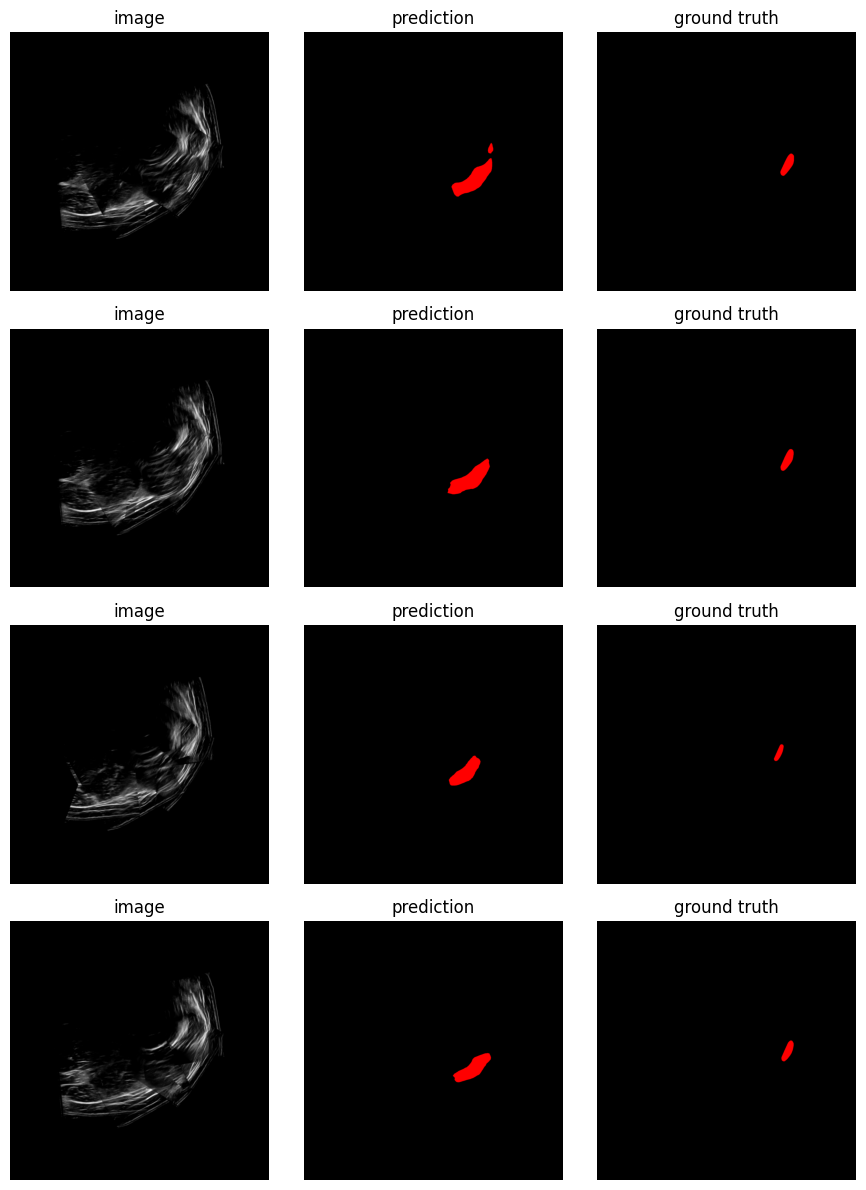

In [9]:
import torch            # 1️⃣ make sure torch is imported
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import random, itertools

visual_dataset = SemanticSegmentationDataset(TEST_IMAGE_DIR, TEST_MASK_DIR, feature_extractor, augment=False)
visual_dataloader = DataLoader(visual_dataset, batch_size=16)
# ─── colour palette ──────────────────────────────────────────────
color_map = {0: (0, 0, 0),         # background  → black
             1: (255, 0, 0)}       # object      → red

def to_rgb(mask: torch.Tensor | np.ndarray) -> np.ndarray:
    """Class‑index mask → H×W×3 RGB image."""
    mask = mask.cpu().numpy()          # work on numpy
    rgb  = np.zeros(mask.shape + (3,), dtype=np.uint8)
    for cls, col in color_map.items():
        rgb[mask == cls] = col
    return rgb

# ─── get one test batch ──────────────────────────────────────────

rand_batch_idx = random.randrange(len(visual_dataloader))
batch = next(itertools.islice(visual_dataloader, rand_batch_idx, None))   
images = batch["pixel_values"]             
masks  = batch["labels"]  # CHW tensors, on CPU

mean = torch.tensor(feature_extractor.image_mean).view(3, 1, 1)
std  = torch.tensor(feature_extractor.image_std).view(3, 1, 1)

def denorm(t: torch.Tensor) -> np.ndarray:
    """Undo (x‑mean)/std → 0‑1 float array ready for imshow."""
    x = (t * std + mean).clamp(0, 1)        # CHW tensor, 0‑1
    return x.permute(1, 2, 0).cpu().numpy() # → HWC


with torch.no_grad():                         # 2️⃣ torch.no_grad, not ns.no_grad
    _, logits = segformer_finetuner.model(images, masks)

# up‑sample 128×128 logits → 512×512, then argmax → predicted mask
logits = torch.nn.functional.interpolate(
            logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)
pred = logits.argmax(dim=1)                   # shape: B×H×W

# ─── visualise first n samples ───────────────────────────────────
k = 4                     # 3️⃣ safe slice
sel = random.sample(range(images.size(0)), k)

plt.figure(figsize=(9, 3*k))
for i, idx in enumerate(sel):
    plt.subplot(k,3,3*i+1); plt.imshow(denorm(images[idx]));     plt.title("image");       plt.axis("off")
    plt.subplot(k,3,3*i+2); plt.imshow(to_rgb(pred[idx].cpu())); plt.title("prediction");  plt.axis("off")
    plt.subplot(k,3,3*i+3); plt.imshow(to_rgb(masks[idx].cpu()));plt.title("ground truth");plt.axis("off")

plt.tight_layout(); plt.show()

In [10]:
export_segformer_ckpt_to_hf(
    ckpt_path="best.ckpt",                     
    out_dir="./segformer_export_hf",           
    base_backbone="nvidia/segformer-b0-finetuned-ade-512-512", 
    num_labels=2,
    id2label={0: "background", 1: "fg"},      
    do_resize=False, do_normalize=True, do_rescale=False
)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[Export] Missing: 0 | Unexpected: 0 | Loaded params: 3715171/3714658
[Export] Saved HF model to: ./segformer_export_hf


In [11]:
# Sanity check
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
m = SegformerForSemanticSegmentation.from_pretrained("./segformer_export_hf")
p = SegformerImageProcessor.from_pretrained("./segformer_export_hf")
print("OK:", type(m).__name__, "num_labels:", m.config.num_labels, "id2label:", m.config.id2label)


OK: SegformerForSemanticSegmentation num_labels: 2 id2label: {0: 'background', 1: 'fg'}
